In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gb-credit-default/sample_submission.csv
/kaggle/input/gb-credit-default/train.csv
/kaggle/input/gb-credit-default/test.csv


## Подключение библиотек и скриптов

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import catboost as catb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score)

import warnings
warnings.filterwarnings('ignore')

In [3]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

## Пути к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = '../input/gb-credit-default/train.csv'
TEST_DATASET_PATH = '../input/gb-credit-default/test.csv'
SAMPLE_SUBMIT_PATH = '../input/gb-credit-default/sample_submission.csv'

## Обзор данных

#### Описание датасета
* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* Monthly Debt - ежемесячный долг
* Credit Score - баллы кредитного рейтинга
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [8]:
df_test.shape

(2500, 16)

#### Обзор обучающего датасета и целевой переменной

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [10]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Обзор количественных признаков

In [11]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


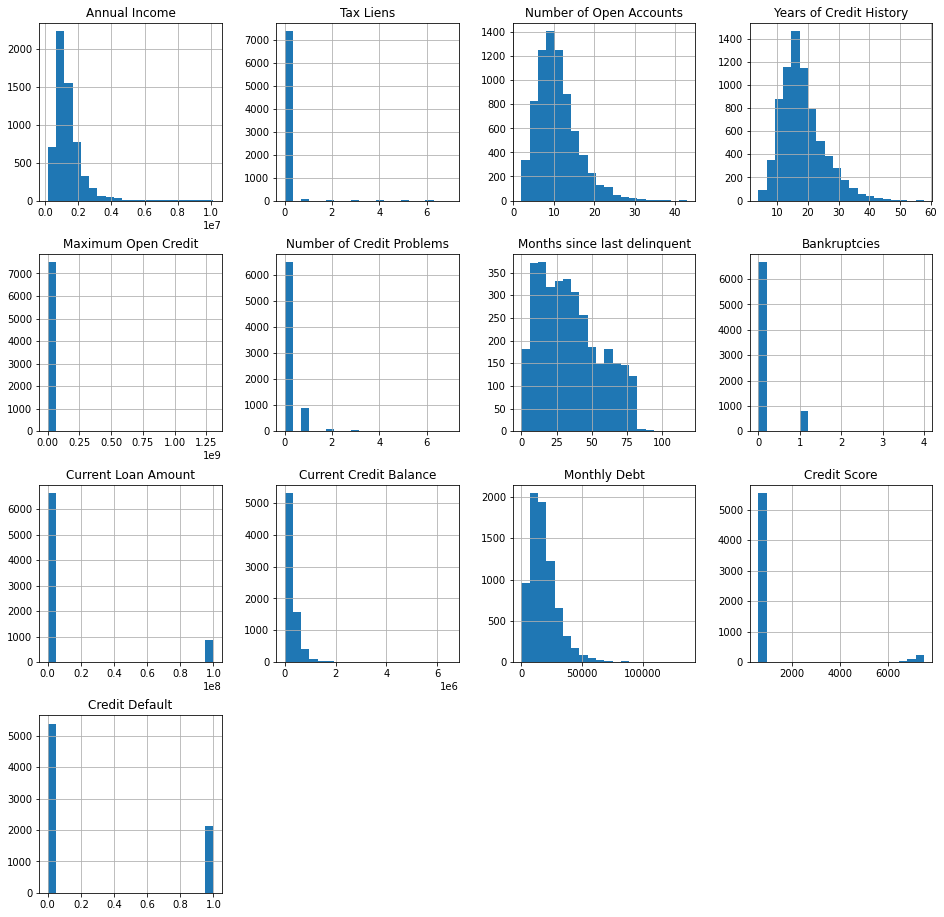

In [12]:
df_train.hist(bins = 20, figsize = (16, 16))
plt.show()

#### Обзор номинативных признаков

In [13]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Матрица корреляции

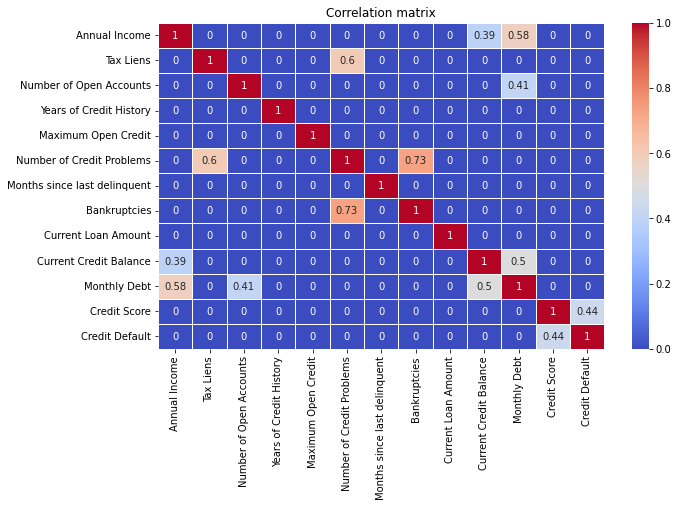

In [14]:
plt.figure(figsize=(10, 6))

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Обработка выбросов.

* Credit Score (баллы кредитного рейтинга)
* Current Loan Amount (текущая сумма кредита)
* Maximum Open Credit (наибольший открытый кредит)
* Months since last delinquent (количество месяцев с последней просрочки платежа)

#### Credit Score (баллы кредитного рейтинга)

In [15]:
df_train[df_train['Credit Score'] <= 850]['Credit Score'].count()

5543

In [16]:
df_train[df_train['Credit Score'] > 1000]['Credit Score'].count()

400

Есть 400 значений в диапазоне более 1000, которые на порядок больше остальных 5543 в диапазоне [300, 850]. с учетом определения кредитного рейтинга FICO credit score, значения между 300–850 описывают кредитоспособность заемщика. https://www.investopedia.com/terms/c/credit_score.asp разделим значения более 850 на 10.

In [17]:
df_train['Credit Score Outlier'] = 0
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score Outlier'] = 1
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] = df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] / 10

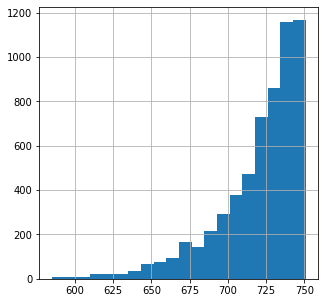

In [18]:
df_train['Credit Score'].hist(bins = 20, figsize = (5, 5))
plt.show()

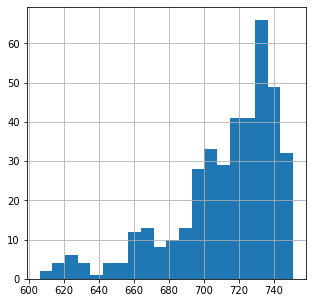

In [19]:
df_train.loc[df_train['Credit Score Outlier'] == 1, 'Credit Score'].hist(bins = 20, figsize = (5, 5))
plt.show()

#### Current Loan Amount (текущая сумма кредита)

In [20]:
df_train['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
222926.0        5
265826.0        5
             ... 
351626.0        1
212498.0        1
187682.0        1
108922.0        1
26928.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

870 значений, на максимуме. Заменим на медиану.

In [21]:
df_train['Current Loan Amount Outlier'] = 0
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount Outlier'] = 1
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df_train['Current Loan Amount'].median()

In [22]:
df_train[df_train['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].count()

0

#### Maximum Open Credit (наибольший открытый кредит) - максимальная сумма, которая когда-либо была доступна клиенту (есть 1 значение 1.3 млрд)

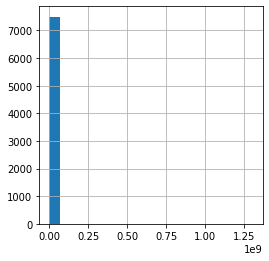

In [23]:
df_train['Maximum Open Credit'].hist(bins = 20, figsize = (4, 4))
plt.show()

в исходных данных максимальное значение поля Current Loan Amount = 99 999 999.00. примем его за максимально возможный кредит

In [24]:
max_credit = 99999999.0

In [25]:
df_train[df_train['Maximum Open Credit'] > max_credit]['Maximum Open Credit'].value_counts()

3.800523e+08    1
1.304726e+09    1
2.655129e+08    1
Name: Maximum Open Credit, dtype: int64

In [26]:
df_train['Maximum Open Credit Outlier'] = 0
df_train.loc[df_train['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
df_train.loc[df_train['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = max_credit

In [27]:
df_train[df_train['Maximum Open Credit Outlier'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Credit Score Outlier,Current Loan Amount Outlier,Maximum Open Credit Outlier
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,99999999.0,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0,0,0,1
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,99999999.0,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0,0,0,1
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,99999999.0,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0,0,0,1


#### Months since last delinquent (количество месяцев с последней просрочки платежа)

In [28]:
df_train['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

In [29]:
NaN_percentage = df_train['Months since last delinquent'].isna().sum() / df_train.shape[0]
NaN_percentage

0.5441333333333334

т.к. отсутствует 50+% данных, то ничего не делаем и дропнем в разделе обработка пропусков.

### Обработка пропусков

In [30]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Credit Score Outlier               0
Current Loan Amount Outlier        0
Maximum Open Credit Outlier        0
dtype: int64

* Annual Income (годовой доход)
* Years in current job (количество лет на текущем месте работы)
* Months since last delinquent (количество месяцев с последней просрочки платежа)
* Bankruptcies (банкротства)
* Credit Score (баллы кредитного рейтинга)

#### Annual Income (годовой доход)
заполняем медианой

In [31]:
df_train['Annual Income'].median()

1168386.0

In [32]:
df_train['Annual Income NaN'] = 0
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income NaN'] = 1
df_train[df_train['Annual Income NaN']==1].count()

Home Ownership                  1557
Annual Income                      0
Years in current job            1482
Tax Liens                       1557
Number of Open Accounts         1557
Years of Credit History         1557
Maximum Open Credit             1557
Number of Credit Problems       1557
Months since last delinquent     683
Bankruptcies                    1555
Purpose                         1557
Term                            1557
Current Loan Amount             1557
Current Credit Balance          1557
Monthly Debt                    1557
Credit Score                       0
Credit Default                  1557
Credit Score Outlier            1557
Current Loan Amount Outlier     1557
Maximum Open Credit Outlier     1557
Annual Income NaN               1557
dtype: int64

In [33]:
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace = True)

In [34]:
df_train['Annual Income'].isna().sum()

0

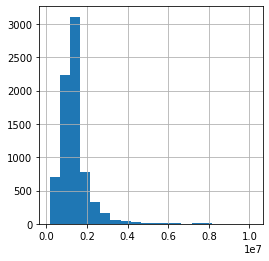

In [35]:
df_train['Annual Income'].hist(bins = 20, figsize = (4, 4))
plt.show()

#### Years in current job (количество лет на текущем месте работы)
Заполним модой.

In [36]:
mode = df_train['Years in current job'].mode().values[0]
mode

'10+ years'

In [37]:
df_train['Years in current job NaN'] = 0
df_train.loc[df_train['Years in current job'].isna(), 'Years in current job NaN'] = 1
df_train['Years in current job'].fillna(mode, inplace = True)

In [38]:
df_train['Years in current job'].isna().sum()

0

#### Months since last delinquent (количество месяцев с последней просрочки платежа)

In [39]:
df_train.drop('Months since last delinquent', axis=1, inplace=True)

#### Bankruptcies (банкротства)

In [40]:
df_train['Bankruptcies'].median()

0.0

In [41]:
df_train['Bankruptcies NaN'] = 0
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
df_train['Bankruptcies'].fillna(df_train['Bankruptcies'].median(), inplace = True)
df_train['Bankruptcies'].isna().sum()

0

#### Credit Score (баллы кредитного рейтинга)

In [42]:
df_train['Credit Score'].median()

729.0

In [43]:
df_train['Credit Score NaN'] = 0
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score NaN'] = 1
df_train['Credit Score'].fillna(df_train['Credit Score'].median(), inplace = True)
df_train['Credit Score'].isna().sum()

0

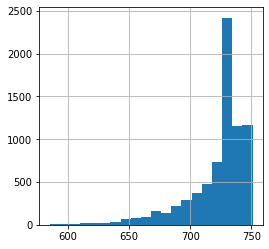

In [44]:
df_train['Credit Score'].hist(bins=20, figsize = (4, 4))
plt.show()

In [45]:
df_train.isna().sum()

Home Ownership                 0
Annual Income                  0
Years in current job           0
Tax Liens                      0
Number of Open Accounts        0
Years of Credit History        0
Maximum Open Credit            0
Number of Credit Problems      0
Bankruptcies                   0
Purpose                        0
Term                           0
Current Loan Amount            0
Current Credit Balance         0
Monthly Debt                   0
Credit Score                   0
Credit Default                 0
Credit Score Outlier           0
Current Loan Amount Outlier    0
Maximum Open Credit Outlier    0
Annual Income NaN              0
Years in current job NaN       0
Bankruptcies NaN               0
Credit Score NaN               0
dtype: int64

### Построение новых признаков
Term (срок кредита) - замена на Long Term (долгосрочный кредит): 1-да, 0-нет

In [46]:
df_train['Long Term'] = df_train['Term'].map({'Long Term': 1, 'Short Term': 0})

#### Years in current job (количество лет на текущем месте работы) - сделаем разбивку на категории:<3, 4-6, 7-9, 10+ лет

In [47]:
df_train['Years in current job'] = df_train['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':0, 
                                                                       '3 years':0, 
                                                                       '4 years':1, 
                                                                       '5 years':1, 
                                                                       '6 years':1, 
                                                                       '7 years':2,
                                                                       '8 years':2,
                                                                       '9 years':2,
                                                                       '10+ years':3})

#### Home ownership (домовладение)

In [48]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Home Ownership'])], axis=1)

Credit Score(баллы кредитного рейтинга) - Сделаем разбивку рейтинга на категории:
* Excellent: 800 to 850
* Very Good: 740 to 799
* Good: 670 to 739
* Fair: 580 to 669
* Poor: 300 to 579

In [49]:
def credit_score_to_cat(X):
    bins = [300, 579, 669, 739, 799, 850]
    X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
    
    X['Credit Score Cat'].fillna(-1, inplace=True)
    return X

In [50]:
df_train = credit_score_to_cat(df_train)

### Классы обработки данных
#### Обработка выбрососв и пропусков

In [51]:
class DataPreparation:
    
    def __init__(self):
        self.medians = None
        self.modes = None
        self.max_score = 850
        self.max_credit = 99999999.0
        
    def fit(self, X):
        """Сохранение статистик"""
        X = X.copy()
        # Расчет медиан и мод
        self.medians = X.median()
        self.modes = X.mode().loc[0]
        
    def transform(self, X):
        """Трансформация данных"""
        
        # Credit Score (баллы кредитного рейтинга)
        X['Credit Score Outlier'] = 0
        X['Credit Score NaN'] = 0
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score Outlier'] = 1
        X.loc[X['Credit Score'].isna(), 'Credit Score NaN'] = 1
        
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] = \
                                X.loc[df_train['Credit Score'] > self.max_score, 'Credit Score'] / 10
        
        # Current Loan Amount (текущая сумма кредита)
        X['Current Loan Amount Outlier'] = 0
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount Outlier'] = 1
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        # Maximum Open Credit (наибольший открытый кредит)
        X['Maximum Open Credit Outlier'] = 0
        X.loc[X['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
        X.loc[X['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = max_credit
        
        # Annual Income (годовой доход)
        X['Annual Income NaN'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual Income NaN'] = 1
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace = True)
        
        # Years in current job (количество лет на текущем месте работы)
        X['Years in current job NaN'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job NaN'] = 1
        X['Years in current job'].fillna(self.modes['Years in current job'], inplace = True)
        
        # Months since last delinquent (количество месяцев с последней просрочки платежа)
        X.drop('Months since last delinquent', axis=1, inplace=True)
        
        # Bankruptcies (банкротства)
        X['Bankruptcies NaN'] = 0
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
        X['Bankruptcies'].fillna(self.medians['Bankruptcies'], inplace = True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

#### Генерация новых признаков

In [52]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def fit(self, X, y=None):
        X = X.copy()
        
    def transform(self, X):
        
        #Term (срок кредита)
        X['Long Term'] = X['Term'].map({'Long Term' : 1, 'Short Term': 0})
        
        # Years in current job (количество лет на текущем месте работы)
        X['Years in current job'] = X['Years in current job']. map({'< 1 year':0,
                                                                   '1 year':0,
                                                                   '2 years':0,
                                                                   '3 years':0,
                                                                   '4 years':1,
                                                                   '5 years':1,
                                                                   '6 years':1,
                                                                   '7 years':2,
                                                                   '8 years':2,
                                                                   '9 years':2,
                                                                   '10+ years':3,})
        
        # Home Ownership (домовладение)
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        
        # Credit Score (баллы кредитного рейтинга)
        X = self.credit_score_to_cat(X)
        
        return X
    
    def credit_score_to_cat(self, X):
        bins = [300, 579, 669, 739, 799, 850]
        X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
        
        X['Credit Score Cat'].fillna(-1, inplace=True)
        return X

#### Отбор признаков

In [53]:
feature_names = ['Annual Income', 
                 'Tax Liens', 
                 'Number of Open Accounts', 
                 'Years of Credit History', 
                 'Maximum Open Credit', 
                 'Number of Credit Problems', 
#                  'Months since last delinquent', 
                 'Bankruptcies',
                 'Current Loan Amount', 
                 'Current Credit Balance', 
                 'Monthly Debt', 
                 'Credit Score', 
                 'Years in current job', 
#                  'Purpose'
                ]

new_feature_names = [
#                          'Home Ownership',
#                          'Term',
#                          'Credit Score Outlier',
#                          'Current Loan Amount Outlier',
#                          'Maximum Open Credit Outlier',
#                          'Annual Income NaN',
#                          'Years in current job NaN',
#                          'Bankruptcies NaN',
#                          'Credit Score NaN',
                         'Long Term',
                         'Have Mortgage',
                         'Home Mortgage',
                         'Own Home',
                         'Rent',
                         'Credit Score Cat'
                    ]

target_name = 'Credit Default'

In [54]:
all_feature_names = (feature_names)+(new_feature_names)
len(all_feature_names)

18

### Разбиение на train и test

In [55]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [56]:
X = df_train.drop(columns=target_name)
y = df_train[target_name]

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=14)

In [58]:
preprocessor = DataPreparation()
preprocessor.fit(X_train) # fit применяем только к X_train

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)

In [59]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 22), (2475, 22), (2500, 22))

In [60]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train) # fit применяем только X_train, y_train

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

In [61]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 28), (2475, 28), (2500, 28))

In [62]:
"""во всех датафреймах оставляем только отобранные признаки (all_feature_names)"""
X_train = X_train[all_feature_names]
X_valid = X_valid[all_feature_names]
df_test = df_test[all_feature_names]

In [63]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 18), (2475, 18), (2500, 18))

In [64]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

In [65]:
X_train.isna().sum()

Annual Income                0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Years in current job         0
Long Term                    0
Have Mortgage                0
Home Mortgage                0
Own Home                     0
Rent                         0
Credit Score Cat             0
dtype: int64

### Построение модели

In [66]:
imbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
imbalance

2.558781869688385

In [67]:
model_catb = catb.CatBoostClassifier(
                                    silent=True,
                                    random_state=14,
                                    class_weights=[1, imbalance],
                                    eval_metric='F1',
                                    early_stopping_rounds=35,
                                    use_best_model=True,
                                    custom_metric=['Precision', 'Recall'],
                                    iterations=150,
                                    max_depth=5,
                                    min_data_in_leaf=5
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [68]:
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN
 0.531
TEST
 0.511
TRAIN

              precision    recall  f1-score   support

           0       0.85      0.61      0.71      3613
           1       0.42      0.73      0.53      1412

    accuracy                           0.64      5025
   macro avg       0.63      0.67      0.62      5025
weighted avg       0.73      0.64      0.66      5025

VALID

              precision    recall  f1-score   support

           0       0.83      0.60      0.70      1774
           1       0.40      0.69      0.51       701

    accuracy                           0.62      2475
   macro avg       0.62      0.64      0.60      2475
weighted avg       0.71      0.62      0.64      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1060  714
1                216  485


#### Важность признаков

In [69]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
7,Current Loan Amount,46.114651
12,Long Term,15.829380
0,Annual Income,11.917783
10,Credit Score,7.636782
17,Credit Score Cat,3.711828
4,Maximum Open Credit,2.686372
11,Years in current job,1.971667
2,Number of Open Accounts,1.865933
9,Monthly Debt,1.797106
3,Years of Credit History,1.643429


#### Прогнозирование на тестовом датасете

In [70]:
df_test.shape

(2500, 18)

In [71]:
submit = pd.read_csv(SAMPLE_SUBMIT_PATH)
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [72]:
predictions = model_catb.predict(df_test)
predictions

array([1, 1, 0, ..., 1, 0, 1])

In [73]:
len(predictions)

2500

In [74]:
submit['Credit Default'] = predictions

In [75]:
submit.to_csv('submit_Credit_default150550.csv', index=False)